In [1]:
%%writefile pickle_numerical_gb_model.py
'''
This script pickles the Gradient Boosting model trained on the categorical and 
continuous values for bills that have moved beyond bill_status Introduced. The 
predicted probabilities will be used in feature-weighted linear stacking with the
probabilities calculated in the nlp model to improve predictions on those.
'''
import pandas as pd
import numpy as np
from my_tools import get_bill_data
import os
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, confusion_matrix, log_loss, roc_curve, roc_auc_score

from sklearn.externals import joblib


data, in_progress = get_bill_data()

# fit to bills that have moved beyond bill_status Introduced
data = data[data['bill_status'] != 'Introduced']

# oversample the minority class to balance the classes
count_class_0, count_class_1 = data.labels.value_counts()

class_0 = data[data['labels'] == 0]
class_1 = data[data['labels'] == 1]

class_1 = class_1.sample(count_class_0, replace=True)

data = pd.concat([class_0, class_1], axis = 0, ignore_index=True)

print('------------------')
print('Limiting dataset to significant numerical and categorical features...')

cols_to_use = [
#             'sponsor',
            'num_of_cosponsors', 
#             'sponsor_party', 
#             'sponsor_state', 
            'num_of_amendments',
            'bill_char_counts', 
            'intro_month', 
            'session', 
            'labels'
            ]

dummy_columns = [
            'intro_month', 
#             'num_of_amendments', 
#             'num_of_cosponsors',
#             'sponsor',
#             'sponsor_party', 
#             'sponsor_state', 
            'session'
            ]

data_features = data.loc[:, cols_to_use]

# get dummies for intro_month, sponsor_party, sponsor_state, session
data_dumm = pd.get_dummies(data_features, columns = dummy_columns, drop_first=False)


# drop last dummy column for each feature to avoid dummy trap
cols_to_drop = ['intro_month_12', 'session_2']
for col in cols_to_drop: 
    data_dumm.drop(col, axis = 1, inplace = True)

# y = data_features.pop('labels').values.astype(int)
y = data_dumm.pop('labels').values.astype(int)

print('------------------')
print('Performing train-test split...')
X_train, X_test, y_train, y_test = train_test_split(data_dumm, y, stratify = y)
# X_train, X_test, y_train, y_test = train_test_split(data_features, y, stratify = y)

print('------------------')
print('Scaling the data...')
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)



print('-------------------')
print('Training Gradient Boosting Classifier with oversampled continuous and categorical data...')
gb = GradientBoostingClassifier(loss= 'deviance',             # default value
                                max_features = None,          # default value
                                learning_rate = .05,
                                n_estimators = 200,           # default value
                                criterion = 'friedman_mse',   # default value
                                min_samples_split = 2,        # default value
                                min_samples_leaf = 1,         # default value
                                max_depth = 8,
                                max_leaf_nodes = None)        # default value

gb.fit(X_train, y_train)

print('-------------------')
print('Getting predictions...')
gb_y_pred = gb.predict(X_test)
gb_y_pred_proba = gb.predict_proba(X_test)[:, 1]

print('-------------------')
print('F1 Score:\t\t{:.4f}'.format(f1_score(y_test, gb_y_pred)))
print('Recall Score:\t\t{:.4f}'.format(recall_score(y_test, gb_y_pred)))
print('Precision Score:\t{:.4f}'.format(precision_score(y_test, gb_y_pred)))
print('Accuracy Score:\t\t{:.4f}'.format(accuracy_score(y_test, gb_y_pred)))
print(confusion_matrix(y_test, gb_y_pred))

gb_fprs, gb_tprs, gb_thresh = roc_curve(y_test, gb_y_pred_proba)


print('-------------------')
print('Pickling the scaler and GradientBoost model...')
gb_pickle_path = 'pickle_files/num_gradientBoost.pkl'
sc_pickle_path = 'pickle_files/num_scaler.pkl'

if os.path.exists(gb_pickle_path):
    os.remove(gb_pickle_path)
joblib.dump(gb, gb_pickle_path)

if os.path.exists(sc_pickle_path):
    os.remove(sc_pickle_path)
joblib.dump(sc, sc_pickle_path)

print('All Pickling comlete. DATA SCIENCE!!!')


Overwriting pickle_numerical_gb_model.py


---------------------------
Categorical and continuous data beyond bill_status Introduced
Oversampled minority class
---------------------------
GradientBoost ROC AUC Score: 		0.8373


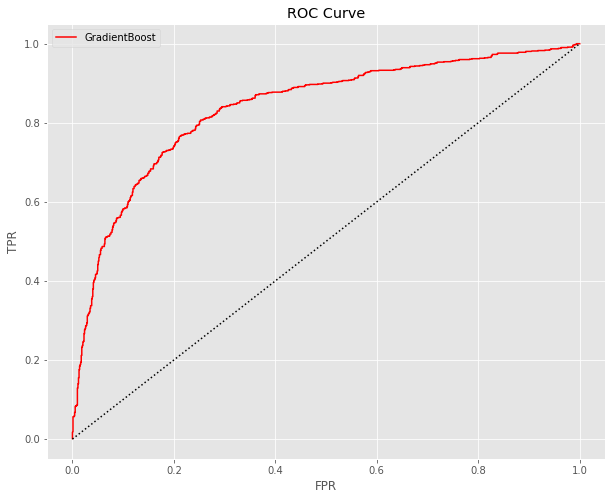

In [2]:
print('---------------------------')
print('Categorical and continuous data beyond bill_status Introduced')
print('Oversampled minority class')
print('---------------------------')
fig = plt.figure(figsize = (10, 8))
plt.plot(gb_fprs, gb_tprs, label = 'GradientBoost', color = 'red')
plt.plot([0, 1], [0, 1], 'k:')
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')

print('GradientBoost ROC AUC Score: \t\t{:.4f}'.format(roc_auc_score(y_test, gb_y_pred_proba)))



In [9]:
# fit new bills that have moved beyond bill_status Introduced
new_data = in_progress[in_progress['bill_status'] != 'Introduced']


print('------------------')
print('Limiting dataset of bills in progress to significant numerical and categorical features...')
new_data_features = new_data.loc[:, cols_to_use]

------------------
Limiting dataset of bills in progress to significant numerical and categorical features...


In [10]:
# get dummies for intro_month, sponsor_party, sponsor_state, session
new_data_dumm = pd.get_dummies(new_data_features, columns = dummy_columns, 
                           drop_first=False)


# modify columns to fit model
new_data_dumm.drop('labels', axis = 1, inplace = True)
for col in data_dumm.columns:
    if col not in new_data_dumm.columns:
        new_data_dumm[col] = 0

In [11]:
new_data_dumm

,num_of_cosponsors,num_of_amendments,bill_char_counts,intro_month_1,session_1,intro_month_2,intro_month_3,intro_month_4,intro_month_5,intro_month_6,intro_month_7,intro_month_8,intro_month_9,intro_month_10,intro_month_11
9,7,0,692,1,1,0,0,0,0,0,0,0,0,0,0
13,1,0,7168,1,1,0,0,0,0,0,0,0,0,0,0
36,0,0,4577,1,1,0,0,0,0,0,0,0,0,0,0
37,2,0,4922,1,1,0,0,0,0,0,0,0,0,0,0
38,2,0,1294,1,1,0,0,0,0,0,0,0,0,0,0
107,0,0,1295706,1,1,0,0,0,0,0,0,0,0,0,0


In [12]:
print('-------------------')
print('Scaling and getting predictions...')
new_data_dumm = sc.transform(new_data_dumm)

gb_y_pred = gb.predict(new_data_dumm)
gb_y_pred_proba = gb.predict_proba(new_data_dumm)[:, 1]


lr_y_pred = lr.predict(new_data_dumm)
lr_y_pred_proba = lr.predict_proba(new_data_dumm)[:, 1]


print('-------------------')
print('GradientBoost Predicted Probabilities')
print(gb_y_pred_proba)

print('-------------------')
print('Logistic Regression Predicted Probabilities')
print(lr_y_pred_proba)

-------------------
Scaling and getting predictions...
-------------------
GradientBoost Predicted Probabilities
[0.26030115 0.22997089 0.29717593 0.35926689 0.27899112 0.37517053]
-------------------
Logistic Regression Predicted Probabilities
[0.44440595 0.44405889 0.44350917 0.44396036 0.44347416 0.61634442]


In [13]:
new_data_dumm.shape

(6, 15)

In [14]:
new_data

,_id,bill_status,bill_text,body,committee,congress_id,cosponsors,cosponsors_url,desc,intro_date,...,sponsor,sponsor_district,sponsor_party,sponsor_state,bill_char_counts,intro_month,intro_year,session,char_count_bucket,labels
9,5c3218041417de098ea2a545,Passed House,To extend by two years the Chemical Facility A...,[Congressional Bills 116th Congress] [From the...,"House - Homeland Security, Energy and Commerce",116,None,https://www.congress.gov/bill/116th-congress/h...,Chemical Facility Anti-Terrorism Standards Pro...,2019-01-04,...,"Thompson, Bennie G.",2,D,MS,692,1,2019,1,less than 1000,in_progress
13,5c3218031417de098ea2a53d,Passed House,To extend the Medicaid Money Follows the Perso...,[Congressional Bills 116th Congress] [From the...,"House - Energy and Commerce, Budget",116,None,https://www.congress.gov/bill/116th-congress/h...,Medicaid Extenders Act of 2019,2019-01-04,...,"Pallone, Frank, Jr.",6,D,NJ,7168,1,2019,1,7001 - 8000,in_progress
36,5c2fb9ca1417de116c271913,Passed House,Making further continuing appropriations for t...,[Congressional Bills 116th Congress] [From the...,House - Appropriations,116,None,None,Making further continuing appropriations for t...,2019-01-03,...,"Lowey, Nita M.",17,D,NY,4577,1,2019,1,4001 - 5000,in_progress
37,5c2fb9ae1417de116c27182f,Passed House,To amend the Small Business Act to specify wha...,[Congressional Bills 116th Congress] [From the...,House - Small Business,116,None,https://www.congress.gov/bill/116th-congress/h...,Incentivizing Fairness in Subcontracting Act,2019-01-03,...,"Velazquez, Nydia M.",7,D,NY,4922,1,2019,1,4001 - 5000,in_progress
38,5c2fb9b81417de116c271892,Passed House,To clarify the primary functions and duties of...,[Congressional Bills 116th Congress] [From the...,House - Small Business,116,None,https://www.congress.gov/bill/116th-congress/h...,Small Business Advocacy Improvements Act of 2019,2019-01-03,...,"Comer, James",1,R,KY,1294,1,2019,1,1001 - 2000,in_progress
107,5c2fb9c21417de116c2718fd,Passed House,Making appropriations for the fiscal year endi...,[Congressional Bills 116th Congress] [From the...,"House - Appropriations, Budget",116,None,None,"Consolidated Appropriations Act, 2019",2019-01-03,...,"Lowey, Nita M.",17,D,NY,1295706,1,2019,1,greater than 10000,in_progress
